Importation des modules nécessaires à l'algorithme

In [1]:
import preprocessing_functions as pre
import SRM_segmentation_functions as SRM
import tests_functions as tests
from skimage import io
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import math
import skimage.morphology as morpho
import valentin as val
import dullrazor as dr
from scipy.spatial import ConvexHull
import multiprocess as mp

Pre-processing : Black Frame Removal

In [2]:
image_dir_train = '/Users/matthieu.kaeppelin/Documents/4-TélécomParis/1-Cours/IMA/IMA-205/ima205-challenge-2024/Train/Train/'
image_dir_test = '/Users/matthieu.kaeppelin/Documents/4-TélécomParis/1-Cours/IMA/IMA-205/ima205-challenge-2024/Test/Test/'
Train_path = image_dir_train

import glob
images_train = glob.glob(Train_path + '/*[0-9].jpg')
mask_img_train = glob.glob(Train_path + '/*seg.png')

images_test = glob.glob(image_dir_test + '/*[0-9].jpg')
mask_img_test = glob.glob(image_dir_test + '/*seg.png')

In [3]:
# Checking if the number of images is right 
print('There are', len(images_train),  'train images')
print('There are', len(mask_img_train),  'train masks')
print('There are', len(images_test),  'test images')
print('There are', len(mask_img_test),  'test masks')

There are 18998 train images
There are 1945 train masks
There are 6333 test images
There are 648 test masks


On importe l'image et on applique les premiers algorithme de preprocessing qui font les modifications suivantes :
- supression des black frames en ligne ou colonne sur les bords de l'image
- application d'un filtre médian
- réduction de la taille de l'image à 150 X 100 pixels

On applique ensuite l'algorithme de ségmentation SRM sur le canal 0 (rouge), 1 (vert), 2 (bleu) ou 3 (moyenne sur les 3 canaux)

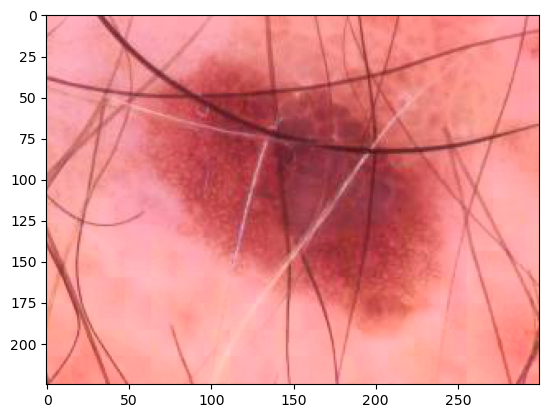

In [4]:
# Load image
image = io.imread(images_train[0])
#image_segmente_corection=io.imread()
image_preprocessed_val = (val.pre_process_temp(images_train[0])*255).astype(np.uint8)
plt.imshow(image_preprocessed_val)


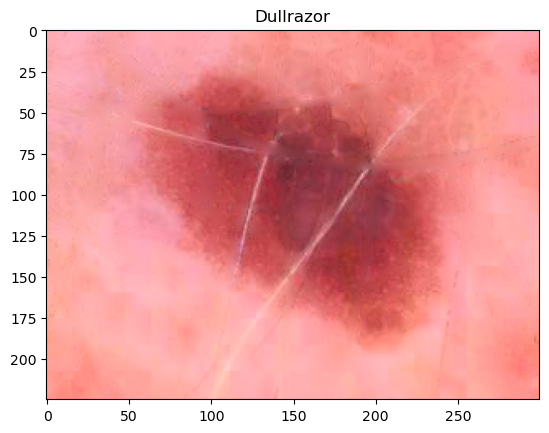

In [5]:
image_preprocessed_nico=dr.dullrazor(image_preprocessed_val)
image_cleaned_rgb = cv.cvtColor(image_preprocessed_nico, cv.COLOR_BGR2RGB)  # Convertir en RGB avant d'afficher
plt.figure()
plt.title("Dullrazor")
plt.imshow(image_cleaned_rgb)


In [6]:
print("Début du préprocessing")
preprocessed_image=pre.preprocessing(image_cleaned_rgb,(150,100))
print("Début de la segmentation")
regions,regions_updated = SRM.SRM_segmentation_3canaux(preprocessed_image,60,2)
print("Création de l'image")
image_regions=SRM.creer_image_regions_3canaux(regions,regions_updated)

Début du préprocessing
Début de la segmentation


/Users/matthieu.kaeppelin/Documents/4-TélécomParis/1-Cours/IMA/IMA-205/ima205-challenge-2024/Projet IMA 201/preprocessing_functions.py:20: RuntimeWarning: overflow encountered in scalar add
  luminosity = (max(im[row][column]) + min(im[row][column])) // 2


Nombre de régions au début:  15000
Nombre de régions restantes:  3
Création de l'image


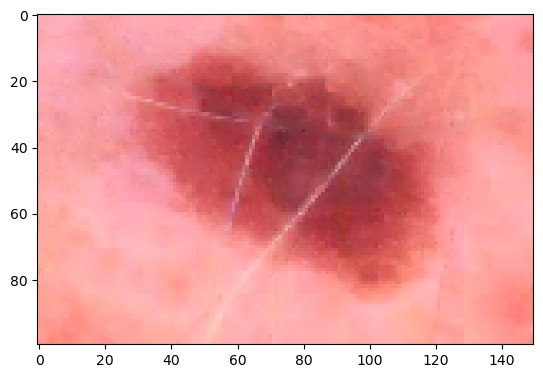

In [7]:
plt.imshow(preprocessed_image)

On affiche l'image résultante de la première ségmentation

Text(0.5, 1.0, 'Image segmentée')

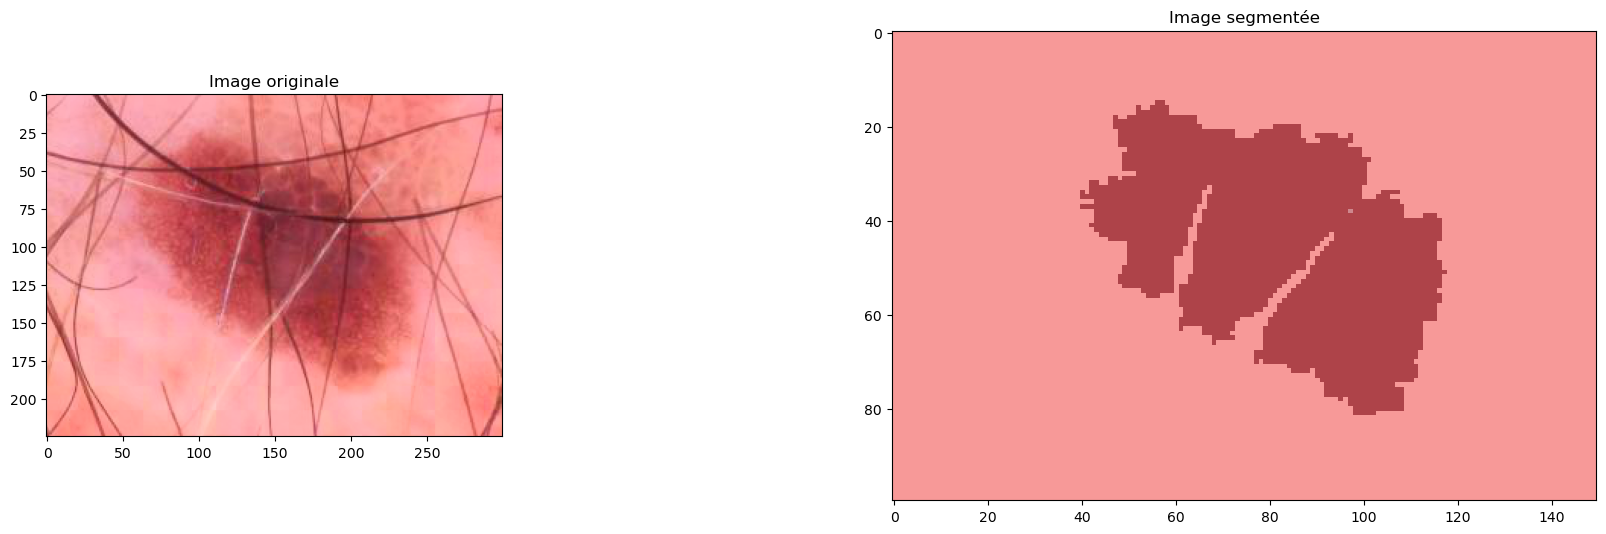

In [8]:
plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.imshow(image_preprocessed_val)
plt.title("Image originale")
plt.subplot(1,2,2)
plt.imshow(image_regions)
plt.title("Image segmentée")


On s'occupe maintenant d'isoler le fond de l'image en identifiant la plus grosse région et en lui donnant une couleur très éloignée de celle constituant la lésion (pas de composante rouge) : le cyan

On supprime aussi les plus petites régions dont la taille est inférieures ou égales à 3 pixels

La région qui a le plus de pixel est la région n°(84, 108)
les coordonnées des régions sont [(84, 108), (39, 97), (38, 97)]
les occurences de ces régions sont [12021, 2978, 1]
84


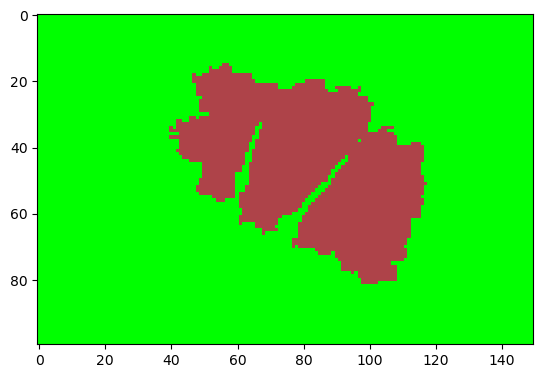

In [9]:

regions=pre.remplacement_fond(regions,regions_updated)
image_regions=SRM.creer_image_regions_3canaux(regions,regions_updated)
plt.imshow(image_regions)


liste_moyennedans count and merge [([0.0, 255.0, 0.0], (38, 97)), ([174.99597044996642, 67.47481531229013, 73.61047683008731], (39, 97)), ([0.0, 255.0, 0.0], (84, 108))]
0
([0.0, 255.0, 0.0], (38, 97))
2
([0.0, 255.0, 0.0], (84, 108))
region supprimé par couleur
2
([0.0, 255.0, 0.0], (84, 108))
0
([0.0, 255.0, 0.0], (38, 97))
region supprimé par couleur


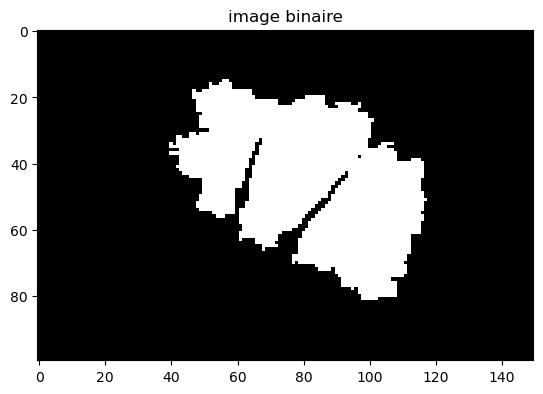

In [10]:
image_regions_binaire_final=SRM.binary_image(regions,regions_updated,0)

On récupère une image binaire en appliquant un algorithme qui attribue la même couleur aux plus grosses régions.

On augmente aussi le seuil de fusion des régions jusqu'a ne plus avoir que 2 couleurs différentes, puis binarise l'image

On applique enfin une dilatation à l'image afin de regrouper les regions et d'agrandir la partie à découper de la lésion

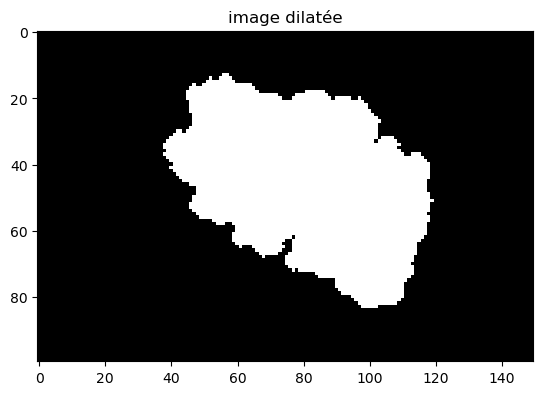

In [11]:
image_dilatee=SRM.dilatation(morpho.disk(2),image_regions_binaire_final)
plt.figure("image dilatée")
plt.title("image dilatée")
plt.imshow(image_dilatee,cmap='gray')


In [12]:
#tests.dice_coefficient(image_dilatee,image_segmente_corection)

In [13]:
import time
import pandas as pd


######ESSAI PARALLELISATION########
from multiprocessing import Pool, cpu_count

def process_image(args):
    print("debut du traitement de l'image", args[0])
    image_name = args
    im = io.imread(image_name)
    image_preprocessed = pre.preprocessing(im, (150, 100))
    image_dullrazored = dr.dullrazor(image_preprocessed)
    image_dullrazored_rgb = cv.cvtColor(image_preprocessed_nico, cv.COLOR_BGR2RGB)
    regions, regions_updated = SRM.SRM_segmentation_3canaux(image_dullrazored_rgb, 30)
    regions = pre.remplacement_fond(regions, regions_updated)
    print(image_name)
    image_regions_binaire_final = SRM.binary_image(regions, regions_updated)
    image_dilatee = SRM.dilatation(morpho.disk(2), image_regions_binaire_final)
    return image_name, image_dilatee

def test_database_multiprocessing(database_à_tester):
    liste_images_dilatees = []
    liste_images_names = []
    print([(image_name) for image_name in database_à_tester])
    with Pool(cpu_count()) as p:
        results = p.map(process_image, [(image_name) for image_name in database_à_tester])
    for image_name, image_dilatee in results:
        liste_images_dilatees.append(image_dilatee)
        liste_images_names.append(image_name)
    return liste_images_dilatees

# Canal Bleu (2)

In [4]:
liste_images_finales, liste_images_names, liste_images_initiales, liste_images_dullrazored, liste_regions_binaire_final = mp.test_database_multiprocessing(images_train[:8],2)

['/Users/matthieu.kaeppelin/Documents/4-TélécomParis/1-Cours/IMA/IMA-205/ima205-challenge-2024/Train/Train/ISIC_0030680.jpg', '/Users/matthieu.kaeppelin/Documents/4-TélécomParis/1-Cours/IMA/IMA-205/ima205-challenge-2024/Train/Train/ISIC_0033389.jpg', '/Users/matthieu.kaeppelin/Documents/4-TélécomParis/1-Cours/IMA/IMA-205/ima205-challenge-2024/Train/Train/ISIC_0013059.jpg', '/Users/matthieu.kaeppelin/Documents/4-TélécomParis/1-Cours/IMA/IMA-205/ima205-challenge-2024/Train/Train/ISIC_0032097.jpg', '/Users/matthieu.kaeppelin/Documents/4-TélécomParis/1-Cours/IMA/IMA-205/ima205-challenge-2024/Train/Train/ISIC_0054312.jpg', '/Users/matthieu.kaeppelin/Documents/4-TélécomParis/1-Cours/IMA/IMA-205/ima205-challenge-2024/Train/Train/ISIC_0032929.jpg', '/Users/matthieu.kaeppelin/Documents/4-TélécomParis/1-Cours/IMA/IMA-205/ima205-challenge-2024/Train/Train/ISIC_0000025.jpg', '/Users/matthieu.kaeppelin/Documents/4-TélécomParis/1-Cours/IMA/IMA-205/ima205-challenge-2024/Train/Train/ISIC_0056263.jpg']

debut du traitement de l'image /Users/matthieu.kaeppelin/Documents/4-TélécomParis/1-Cours/IMA/IMA-205/ima205-challenge-2024/Train/Train/ISIC_0000025.jpg
debut du traitement de l'image /Users/matthieu.kaeppelin/Documents/4-TélécomParis/1-Cours/IMA/IMA-205/ima205-challenge-2024/Train/Train/ISIC_0056263.jpg
debut du traitement de l'image /Users/matthieu.kaeppelin/Documents/4-TélécomParis/1-Cours/IMA/IMA-205/ima205-challenge-2024/Train/Train/ISIC_0033389.jpg
debut du traitement de l'image /Users/matthieu.kaeppelin/Documents/4-TélécomParis/1-Cours/IMA/IMA-205/ima205-challenge-2024/Train/Train/ISIC_0030680.jpg
debut du traitement de l'image /Users/matthieu.kaeppelin/Documents/4-TélécomParis/1-Cours/IMA/IMA-205/ima205-challenge-2024/Train/Train/ISIC_0054312.jpg
debut du traitement de l'image /Users/matthieu.kaeppelin/Documents/4-TélécomParis/1-Cours/IMA/IMA-205/ima205-challenge-2024/Train/Train/ISIC_0032097.jpg
debut du traitement de l'image /Users/matthieu.kaeppelin/Documents/4-TélécomParis/

/Users/matthieu.kaeppelin/Documents/4-TélécomParis/1-Cours/IMA/IMA-205/ima205-challenge-2024/Projet IMA 201/preprocessing_functions.py:20: RuntimeWarning: overflow encountered in scalar add
  luminosity = (max(im[row][column]) + min(im[row][column])) // 2
/Users/matthieu.kaeppelin/Documents/4-TélécomParis/1-Cours/IMA/IMA-205/ima205-challenge-2024/Projet IMA 201/preprocessing_functions.py:20: RuntimeWarning: overflow encountered in scalar add
  luminosity = (max(im[row][column]) + min(im[row][column])) // 2
/Users/matthieu.kaeppelin/Documents/4-TélécomParis/1-Cours/IMA/IMA-205/ima205-challenge-2024/Projet IMA 201/preprocessing_functions.py:20: RuntimeWarning: overflow encountered in scalar add
  luminosity = (max(im[row][column]) + min(im[row][column])) // 2
/Users/matthieu.kaeppelin/Documents/4-TélécomParis/1-Cours/IMA/IMA-205/ima205-challenge-2024/Projet IMA 201/preprocessing_functions.py:20: RuntimeWarning: overflow encountered in scalar add
  luminosity = (max(im[row][column

Nombre de régions au début:  15000
Nombre de régions au début:  15000
Nombre de régions au début:  15000
Nombre de régions au début:  15000
Nombre de régions au début:  15000
Nombre de régions au début:  15000
Nombre de régions au début:  15000
Nombre de régions au début:  15000
Nombre de régions restantes:  18
La région qui a le plus de pixel est la région n°(85, 106)
les coordonnées des régions sont [(85, 106), (10, 62), (11, 60), (12, 54), (18, 36), (16, 49), (18, 111), (20, 115), (21, 117), (22, 118), (24, 121), (32, 129), (33, 130), (41, 30), (61, 51), (63, 132), (72, 83), (84, 108)]
les occurences de ces régions sont [10019, 24, 962, 2, 623, 3334, 2, 1, 1, 1, 13, 1, 2, 1, 1, 6, 2, 5]
85
/Users/matthieu.kaeppelin/Documents/4-TélécomParis/1-Cours/IMA/IMA-205/ima205-challenge-2024/Train/Train/ISIC_0056263.jpg
liste_moyennedans count and merge [([0.0, 255.0, 0.0], (10, 62)), ([65.32536382536382, 67.47920997920998, 72.16943866943868], (11, 60)), ([0.0, 255.0, 0.0], (12, 54)), ([109.06

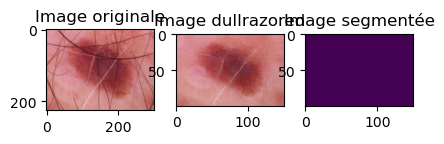

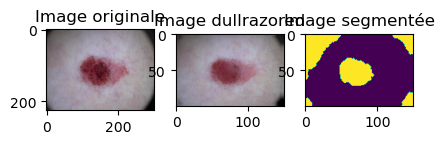

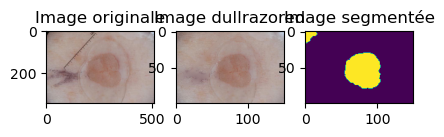

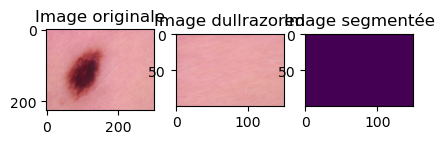

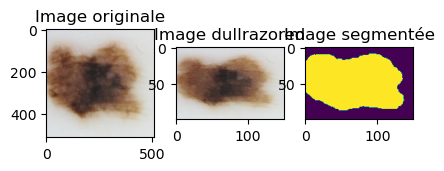

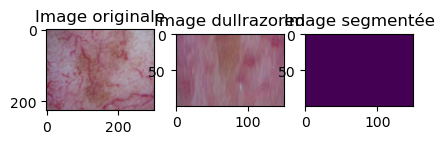

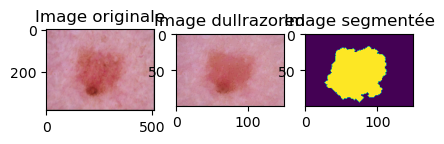

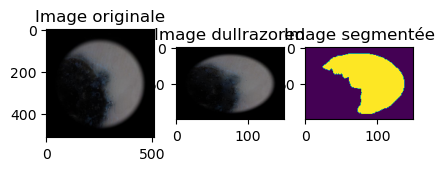

In [5]:
for image_finale, image_initiale, image_dullrazored, image_name in zip(liste_images_finales, liste_images_initiales, liste_images_dullrazored, liste_images_names):
    plt.figure()
    plt.subplot(1, 4, 1)
    plt.imshow(image_initiale)
    plt.title("Image originale")
    plt.subplot(1, 4, 2)
    plt.imshow(image_dullrazored)
    plt.title("Image dullrazored")
    plt.subplot(1, 4, 3)
    plt.imshow(image_finale)
    plt.title("Image segmentée")

# Canal Rouge (0)

In [6]:
liste_images_finales, liste_images_names, liste_images_initiales, liste_images_dullrazored, liste_regions_binaire_final = mp.test_database_multiprocessing(images_train[:8],0)

['/Users/matthieu.kaeppelin/Documents/4-TélécomParis/1-Cours/IMA/IMA-205/ima205-challenge-2024/Train/Train/ISIC_0030680.jpg', '/Users/matthieu.kaeppelin/Documents/4-TélécomParis/1-Cours/IMA/IMA-205/ima205-challenge-2024/Train/Train/ISIC_0033389.jpg', '/Users/matthieu.kaeppelin/Documents/4-TélécomParis/1-Cours/IMA/IMA-205/ima205-challenge-2024/Train/Train/ISIC_0013059.jpg', '/Users/matthieu.kaeppelin/Documents/4-TélécomParis/1-Cours/IMA/IMA-205/ima205-challenge-2024/Train/Train/ISIC_0032097.jpg', '/Users/matthieu.kaeppelin/Documents/4-TélécomParis/1-Cours/IMA/IMA-205/ima205-challenge-2024/Train/Train/ISIC_0054312.jpg', '/Users/matthieu.kaeppelin/Documents/4-TélécomParis/1-Cours/IMA/IMA-205/ima205-challenge-2024/Train/Train/ISIC_0032929.jpg', '/Users/matthieu.kaeppelin/Documents/4-TélécomParis/1-Cours/IMA/IMA-205/ima205-challenge-2024/Train/Train/ISIC_0000025.jpg', '/Users/matthieu.kaeppelin/Documents/4-TélécomParis/1-Cours/IMA/IMA-205/ima205-challenge-2024/Train/Train/ISIC_0056263.jpg']

/Users/matthieu.kaeppelin/Documents/4-TélécomParis/1-Cours/IMA/IMA-205/ima205-challenge-2024/Projet IMA 201/preprocessing_functions.py:20: RuntimeWarning: overflow encountered in scalar add
  luminosity = (max(im[row][column]) + min(im[row][column])) // 2
/Users/matthieu.kaeppelin/Documents/4-TélécomParis/1-Cours/IMA/IMA-205/ima205-challenge-2024/Projet IMA 201/preprocessing_functions.py:20: RuntimeWarning: overflow encountered in scalar add
  luminosity = (max(im[row][column]) + min(im[row][column])) // 2
/Users/matthieu.kaeppelin/Documents/4-TélécomParis/1-Cours/IMA/IMA-205/ima205-challenge-2024/Projet IMA 201/preprocessing_functions.py:20: RuntimeWarning: overflow encountered in scalar add
  luminosity = (max(im[row][column]) + min(im[row][column])) // 2
/Users/matthieu.kaeppelin/Documents/4-TélécomParis/1-Cours/IMA/IMA-205/ima205-challenge-2024/Projet IMA 201/preprocessing_functions.py:20: RuntimeWarning: overflow encountered in scalar add
  luminosity = (max(im[row][column

Nombre de régions au début:  15000
Nombre de régions au début:  15000
Nombre de régions au début:  15000
Nombre de régions au début:  15000
Nombre de régions au début:  15000
Nombre de régions au début:  15000
Nombre de régions au début:  15000
Nombre de régions au début:  15000
Nombre de régions restantes:  6
La région qui a le plus de pixel est la région n°(89, 96)
les coordonnées des régions sont [(89, 96), (12, 50), (11, 67), (41, 30), (55, 83), (88, 76)]
les occurences de ces régions sont [9722, 1526, 3748, 1, 2, 1]
89
/Users/matthieu.kaeppelin/Documents/4-TélécomParis/1-Cours/IMA/IMA-205/ima205-challenge-2024/Train/Train/ISIC_0056263.jpg
liste_moyennedans count and merge [([105.76467449306297, 104.43703308431164, 106.9474386339381], (11, 67)), ([38.27260812581913, 41.22870249017038, 46.20904325032765], (12, 50)), ([0.0, 255.0, 0.0], (41, 30)), ([0.0, 255.0, 0.0], (55, 83)), ([0.0, 255.0, 0.0], (88, 76)), ([0.0, 255.0, 0.0], (89, 96))]
2
([0.0, 255.0, 0.0], (41, 30))
3
([0.0, 255.

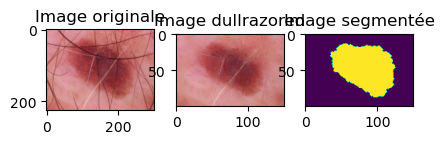

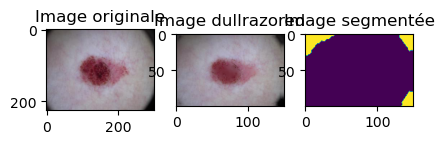

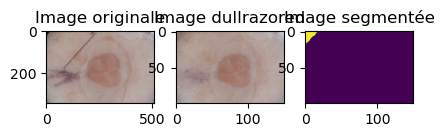

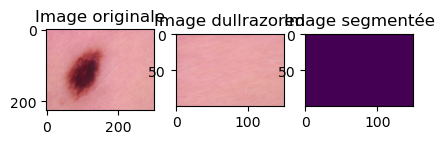

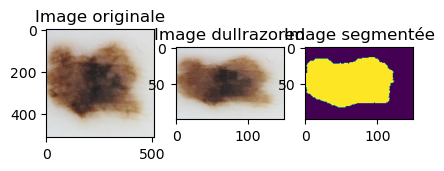

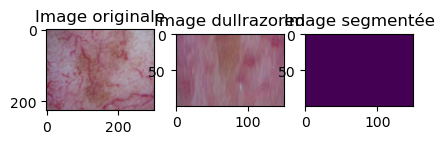

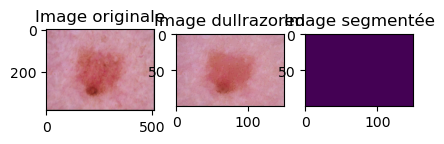

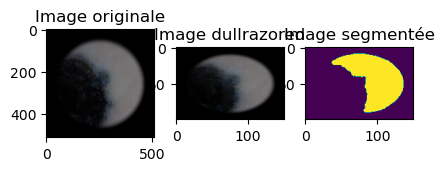

In [7]:
for image_finale, image_initiale, image_dullrazored, image_name in zip(liste_images_finales, liste_images_initiales, liste_images_dullrazored, liste_images_names):
    plt.figure()
    plt.subplot(1, 4, 1)
    plt.imshow(image_initiale)
    plt.title("Image originale")
    plt.subplot(1, 4, 2)
    plt.imshow(image_dullrazored)
    plt.title("Image dullrazored")
    plt.subplot(1, 4, 3)
    plt.imshow(image_finale)
    plt.title("Image segmentée")